In [1]:
import finetune_resnet
import h5py
from keras.metrics import sparse_categorical_accuracy
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.utils.io_utils import HDF5Matrix
import numpy as np
import matplotlib.pyplot as plt

C:\tools\miniconda3\lib\site-packages\h5py\__init__.py:75: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
debug = False
start, end = None, None
if debug == True:
    start, end = 0, 400

In [3]:
x = HDF5Matrix("../Market-1501/market.h5", "train_images", start=start, end=end)
attributes_target = HDF5Matrix("../Market-1501/market.h5", "train_labels", start=start, end=end)
file_names = HDF5Matrix("../Market-1501/market.h5", "train_images_files", start=start, end=end)
ids_encoder = dict()
train_ids = np.zeros(len(file_names), dtype=int)
i = 0
for j, file in enumerate(file_names):
    if file[:4] not in ids_encoder:
        ids_encoder[file[:4]] = i
        i += 1
    train_ids[j] = ids_encoder[file[:4]]
n_id = len(ids_encoder)
n_id

27

In [4]:
train_ids.shape, n_id

((400,), 27)

In [5]:
_, training_model, inference_model = finetune_resnet.get_models(n_person=n_id)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 64, 3)   0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    input_1[0][0]                    
__________________________________________________________________________________________________
attributes (Dense)              (None, 27)           55323       resnet50[1][0]                   
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          1049088     resnet50[1][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [15]:
# lambda 0.9 from paper
lam = 0.9

optim = SGD()

training_model.compile(
    optimizer=optim,
    loss=["binary_crossentropy", "sparse_categorical_crossentropy"], 
    metrics={"attributes":[finetune_resnet.market_attribute_accuracy], "ids":[sparse_categorical_accuracy]},
    loss_weights=[1 - lam, lam],
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
validation_split = 0.2
data_augmentation = finetune_resnet.marketDataGenerator(
    x,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function=finetune_resnet.preprocess_images,
    validation_split=validation_split
)

In [25]:
experiment_name = "full-model-weights"
initial_epoch = 0
if initial_epoch > 0:
    training_model.load_weights(f"../models/{experiment_name}-{initial_epoch}.h5")

cb = [
    ModelCheckpoint(f"../models/{experiment_name}-{{epoch:02d}}.h5", save_weights_only=True),
    EarlyStopping(monitor="loss"),
    LearningRateScheduler(lambda epoch:0.01 if epoch < 50 else 0.001)
]
epochs = 60
batch_size = 32

history = training_model.fit_generator(
    data_augmentation(
        images=x,
        attributes=finetune_resnet.preprocess_labels(np.array(attributes_target)),
        ids=train_ids,
        batch_size=batch_size,
        subset="training"
    ),
    steps_per_epoch=len(x) * (1 - validation_split) // batch_size,
    epochs=epochs,
    callbacks=cb,
    initial_epoch=initial_epoch,
    validation_steps=len(x) * validation_split // batch_size,
    validation_data=data_augmentation(
        images=x,
        attributes=finetune_resnet.preprocess_labels(np.array(attributes_target)),
        ids=train_ids,
        batch_size=batch_size,
        subset="validation"
    )
)

Epoch 41/60
10/10 [==============================] - 52s 5s/step - loss: 0.3053 - attributes_loss: 0.7141 - ids_loss: 0.2598 - attributes_market_attribute_accuracy: 0.4988 - ids_sparse_categorical_accuracy: 0.9313 - val_loss: 4.8977 - val_attributes_loss: 0.7578 - val_ids_loss: 5.3577 - val_attributes_market_attribute_accuracy: 0.3841 - val_ids_sparse_categorical_accuracy: 0.0000e+00
Epoch 42/60
10/10 [==============================] - 56s 6s/step - loss: 0.2610 - attributes_loss: 0.6934 - ids_loss: 0.2129 - attributes_market_attribute_accuracy: 0.5119 - ids_sparse_categorical_accuracy: 0.9563 - val_loss: 5.0338 - val_attributes_loss: 0.7633 - val_ids_loss: 5.5083 - val_attributes_market_attribute_accuracy: 0.4150 - val_ids_sparse_categorical_accuracy: 0.0208
Epoch 43/60
10/10 [==============================] - 54s 5s/step - loss: 0.2265 - attributes_loss: 0.6783 - ids_loss: 0.1763 - attributes_market_attribute_accuracy: 0.5166 - ids_sparse_categorical_accuracy: 0.9594 - val_loss: 5.28

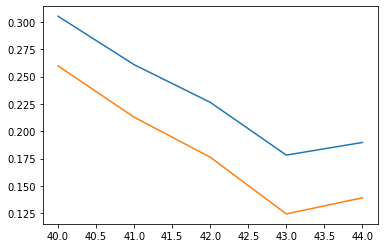

In [40]:
xabs = list(range(initial_epoch, initial_epoch + len(history.history["loss"])))
plt.plot(xabs, history.history["loss"])
plt.plot(xabs, history.history["ids_loss"])

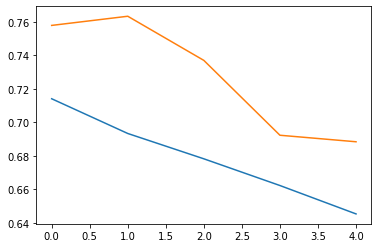

In [32]:
plt.plot(xabs, history.history["attributes_loss"])
plt.plot(xabs, history.history["val_attributes_loss"])

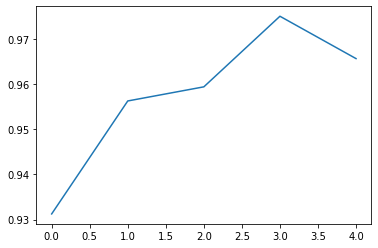

In [34]:
plt.plot(xabs, history.history["ids_sparse_categorical_accuracy"])

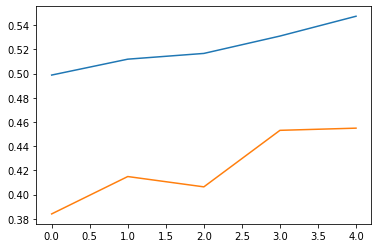

In [35]:
plt.plot(xabs, history.history["attributes_market_attribute_accuracy"])
plt.plot(xabs, history.history["val_attributes_market_attribute_accuracy"])

In [37]:
# test function with query - gallery
test_data = np.array([
    x[0], x[1], x[2], x[100], x[200]
])
res = inference_model.predict(finetune_resnet.preprocess_images(test_data))

In [38]:
# 0 1 2 are the same person, 3, 4 are different persons
dist = [
    np.linalg.norm(res[0] - res[1]),
    np.linalg.norm(res[0] - res[2]),
    np.linalg.norm(res[0] - res[3]),
    np.linalg.norm(res[0] - res[4]),
]
list(zip(dist, ("same", "same", "other1", "other2")))

[(23.417528, 'same'),
 (24.644224, 'same'),
 (39.326782, 'other1'),
 (40.988445, 'other2')]

Use evaluation.ipynb to get all the metrics on test set